In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import islice
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from keras.utils import to_categorical
from sklearn.preprocessing import label_binarize
import itertools  # Add this import statement

# Adatbeolvasás

## Patientdata
Az eredeti csv feldolgozása már tanulásra előkészített adatokkal

In [2]:
readIn = pd.read_csv("data/df_patientdata.csv")
df_patientdata= pd.DataFrame(readIn)

In [3]:
df_patientdata.head(50)

,PatientID,Pathology,Is_Male,Age_Group_3,Age_Group_4,Age_Group_5,Age_Group_6,Age_Group_7,Age_Group_8
0,SCD0000101,1,1,False,False,True,False,False,False
1,SCD0000201,1,1,False,True,False,False,False,False
2,SCD0000301,1,1,False,False,False,False,True,False
3,SCD0000401,1,1,False,True,False,False,False,False
4,SCD0000501,1,1,False,False,False,True,False,False
5,SCD0000601,1,1,False,False,False,False,True,False
6,SCD0000701,1,1,False,True,False,False,False,False
7,SCD0000801,1,1,False,False,True,False,False,False
8,SCD0000901,1,1,False,False,False,True,False,False
9,SCD0001001,1,1,False,False,True,False,False,False


## Image data
A dicom fájlokból egységesített, normalizált képek. 
- Numpy tömbben
- Méretük: (256,256)
- Minden pixelhez csak egy érték tartozik, értékük 0-1 között van

Disclaimer!! Ez pár percig el fog tartani

In [4]:
images = np.load('data/images.npz', allow_pickle=True)

In [5]:
loaded_ids = images['ids']

In [6]:
loaded_images = images['images']

In [7]:
image_data=[]
i=0
print('start')
for id, image in zip(loaded_ids, loaded_images):
    print(f'Processing {i}', end='\r')
    image_data.append([id, image.flatten()])
    i+=1

start


In [8]:
df_images =pd.DataFrame(image_data, columns=['PatientID', 'Image'])

In [9]:
'''import numpy as np
np.set_printoptions(threshold=np.inf)
print(df_images['Image'][0])'''

"import numpy as np\nnp.set_printoptions(threshold=np.inf)\nprint(df_images['Image'][0])"

# Effective data loading

Amit megértettem ebből az az, hogy ahogy több órán is láthattuk, mind train-nél, mind eval-nál az adatokat batchekben kapja meg a program így könnyítve a feldolgozást. Ehhez készítettem egy sablont, ezt tudjátok használni. Ha példát szeretnétek látni a működéséről, akkor nyissátok meg a 2 - Data preparation.ipynb-t, ott több helyen használom.

A cellát duplikáljátok és az eredetit hagyjátok meg itt fenn, jól fog az még jönni :D

In [10]:
nagy_adathalmaz=[] #valami random adat itt, ez nem üres array!

feldolgozott_adat=[]

max_batch=len(nagy_adathalmaz)      #Alapesetben az adatunk hossza!
                                    #Ha csak tesztelni akarod a működést, akkor érdemes lejjebb állítani, hogy értelmes időn belül végezzen

batch_size = 50      # Válaszd meg a megfelelő batch méretet. Ha kisebb akkor nem fogja annyira terhelni a gépet, de lassabb lesz

for i in range(0, max_batch, batch_size):     #0-tól megyünk max_batch-ig, batch_size ugrásokkal
    batch = islice(nagy_adathalmaz, i, i + batch_size)     # csinálunk egy batch-nyni adatot az eredeti adatunkból az iteráció állapota alapján
    print(f'Processing {i}', end='\r')      # Opcionális sor, de türelmetleneknek (vagyis nekem) hasznos: látom hogy épp hol tart a futás
    batch_data = []     #array a batchenkénti adatnak
    for item in batch:
        
        # itt csinálsz valamit az adatokkal amik item néven futnak, pl.: tanítasz
        
        batch_data.append(item)       # összegyűjtöd az adatokat batchenként
        
    feldolgozott_adat.extend(batch_data)     # belerakod batchenként az adatot a nagy tömbbe.


# Training

## Merge image and patient data dataframes

In [11]:
merged_df = pd.merge(df_patientdata, df_images, on='PatientID', how='inner')

In [12]:
merged_df.shape

(2500, 10)

## Prepare data for training

In [13]:
X = merged_df.drop(['PatientID', 'Pathology'], axis=1)  # Exclude non-essential columns
y = merged_df['Pathology']

In [14]:
'''def flatten_images_generator(image_data):
    for image in image_data:
        yield image.flatten()

# Initialize an empty list to store flattened images
flattened_images = []

# Define batch size for processing images in smaller chunks
batch_size = 20  # Adjust this based on your system's memory capacity

# Iterate through the image data in batches and flatten
for idx in range(0, len(images), batch_size):
    batch_flattened = list(flatten_images_generator(images[idx:idx+batch_size]))
    flattened_images.extend(batch_flattened)'''

"def flatten_images_generator(image_data):\n    for image in image_data:\n        yield image.flatten()\n\n# Initialize an empty list to store flattened images\nflattened_images = []\n\n# Define batch size for processing images in smaller chunks\nbatch_size = 20  # Adjust this based on your system's memory capacity\n\n# Iterate through the image data in batches and flatten\nfor idx in range(0, len(images), batch_size):\n    batch_flattened = list(flatten_images_generator(images[idx:idx+batch_size]))\n    flattened_images.extend(batch_flattened)"

## Train-test split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_image_train = X_train['Image'].tolist()
X_patient_data_train = X_train.drop(['Image'], axis=1)
X_image_test = X_test['Image'].tolist()
X_patient_data_test = X_test.drop(['Image'], axis=1)

## Model and fitting

In [16]:
# Training image data
image_classifier = RandomForestClassifier()
image_classifier.fit(X_image_train, y_train)

# Training patient data
patient_data_classifier = RandomForestClassifier()
patient_data_classifier.fit(X_patient_data_train, y_train)

RandomForestClassifier()

In [17]:
# Predicting image data
#y_image_pred = image_classifier.predict(X_image_test)
#accuracy = accuracy_score(y_test, y_image_pred)
#print(f"Image data accuracy: {accuracy}")

# Additional evaluation metrics (optional)
#print(classification_report(y_test, y_image_pred))

Image data accuracy: 0.84
              precision    recall  f1-score   support

           0       0.93      0.83      0.87       110
           1       0.81      0.85      0.83       110
           2       0.77      0.88      0.82       143
           3       0.89      0.80      0.84       137

    accuracy                           0.84       500
   macro avg       0.85      0.84      0.84       500
weighted avg       0.85      0.84      0.84       500



In [18]:
# Predicting patient data
#y_patient_data_pred = patient_data_classifier.predict(X_patient_data_test)
#accuracy = accuracy_score(y_test, y_patient_data_pred)
#print(f"Patient data accuracy: {accuracy}")

# Additional evaluation metrics (optional)
#print(classification_report(y_test, y_patient_data_pred))

Patient data accuracy: 0.508
              precision    recall  f1-score   support

           0       0.36      0.43      0.39       110
           1       0.54      0.30      0.39       110
           2       0.51      0.72      0.60       143
           3       0.68      0.52      0.59       137

    accuracy                           0.51       500
   macro avg       0.52      0.49      0.49       500
weighted avg       0.53      0.51      0.50       500



# Evaluation

Teljesítményértékelő metrikák többosztályos klasszifikációs problémákhoz:

    - Confusion Matrix (--> accuracy, precision, recall, F1 score)
    - ROC-AUC
    
ToDo a végleges leadásra: vizualizáció

In [87]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [93]:
def plot_roc_curve(y_true, y_pred_probs, classes):
    """
    This function plots the ROC curve for each class.
    """
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    lw = 2
    colors = ['darkorange', 'green', 'blue', 'red', 'purple']  # Adjust the colors based on the number of classes

    for i, color in zip(range(len(classes)), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve (area = {:.2f})'.format(roc_auc[i]))

    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

In [99]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, classes=["Class 0", "Class 1", "Class 2", "Class 3"], normalize=True)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Precision, Recall, F1 Score
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # ROC-AUC
    y_pred_probs = model.predict_proba(X_test)
    roc_auc = roc_auc_score(y_test, y_pred_probs, multi_class='ovr', average='weighted')
    
    y_true_binary = label_binarize(y_test, classes=[0, 1, 2, 3])  # Adjust classes based on your specific problem
    plot_roc_curve(y_true_binary, y_pred_probs, classes=["Class 0", "Class 1", "Class 2", "Class 3"])
    
    #print("Confusion Matrix:\n", cm)
    print("Accuracy: {:.4f}".format(accuracy))
    print("Precision: {:.4f}".format(precision))
    print("Recall: {:.4f}".format(recall))
    print("F1 Score: {:.4f}".format(f1))
    print("ROC-AUC: {:.4f}".format(roc_auc))

Normalized confusion matrix


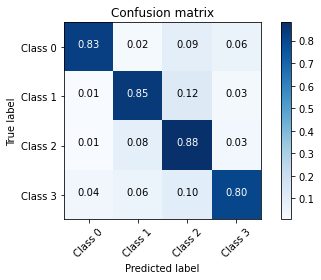

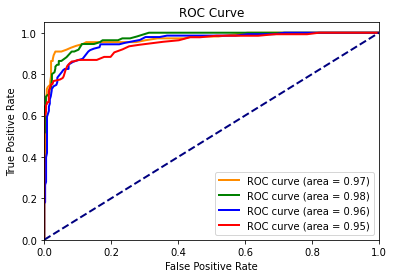

Accuracy: 0.8400
Precision: 0.8463
Recall: 0.8400
F1 Score: 0.8409
ROC-AUC: 0.9614


In [100]:
evaluate_model(image_classifier, X_image_test, y_test)

Normalized confusion matrix


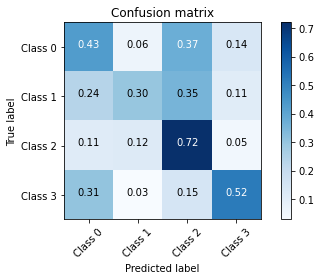

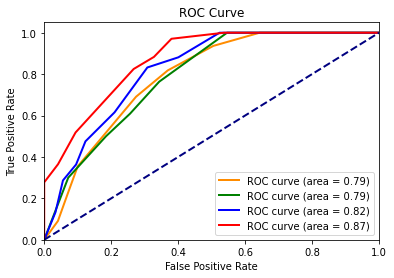

Accuracy: 0.5080
Precision: 0.5283
Recall: 0.5080
F1 Score: 0.5018
ROC-AUC: 0.8200


In [101]:
evaluate_model(patient_data_classifier, X_patient_data_test, y_test)